In [1]:
import pandas as pd
import scipy.io
import scipy.signal as ss
import pywt
import glob
import matplotlib.pyplot as plt
import scaleogram as scg
from scaleogram import cws
import numpy as np
from math import *
import os

In [2]:
print(os.getcwd())
for x in range(1):
    os.chdir('..')
print (os.getcwd())

/Users/hoangminhthao/Documents/GitHub/HeartResearch/Data Preprocessing
/Users/hoangminhthao/Documents/GitHub/HeartResearch


In [3]:
main_data_dir = os.getcwd() + "/Data set"
print(os.listdir(main_data_dir))

['.DS_Store', 'Gaussian_Filter', 'TrainingSet1', 'Median_Filter', 'README.md', 'Label.csv', 'Scaleogram_512_256', 'Output.png', 'TrainingSet3', 'TrainingSet2']


In [5]:
data_mat_files = glob.glob(main_data_dir + "/TrainingSet*/*")

In [6]:
mat = scipy.io.loadmat(data_mat_files[0])
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Dec 19 15:30:07 2017', '__version__': '1.0', '__globals__': [], 'ECG': array([[(array(['Female'], dtype='<U6'), array([[34]], dtype=uint8), array([[ 1.73768069e-02,  1.71725761e-02,  6.27266857e-03, ...,
                 5.66224605e-04, -3.98646404e-03, -4.72333344e-03],
               [ 2.73954729e-02,  1.91244035e-02,  8.96867281e-03, ...,
                 5.90927328e-02,  5.88357940e-02,  5.63322547e-02],
               [ 1.00186659e-02,  1.95182742e-03,  2.69600424e-03, ...,
                 5.85265082e-02,  6.28222581e-02,  6.10555882e-02],
               ...,
               [ 1.55362648e-01,  2.27003440e-01,  2.08681742e-01, ...,
                -1.75072873e-02, -2.21225776e-02, -2.85125191e-02],
               [ 4.89187271e-01,  6.99974197e-01,  6.39584023e-01, ...,
                 1.08587053e-01,  9.61002216e-02,  1.01143936e-01],
               [ 1.14240268e+00,  1.61560312e+00,  1.44965444e+00, ...,
   

In [8]:
def data_extract(signal_raw_list, min_len = 3000):
    signal_number_list = []
    signal_list = []
    
    for signal in signal_raw_list:
        mat = scipy.io.loadmat(signal)
        signal_list.append(mat['ECG'][0][0][2][:,:min_len])
        signal_number = signal.split('/')[-1].split('.')[0]
        signal_number_list.append(signal_number)

    return (np.array(signal_list), signal_number_list)

signal_list, signal_number = data_extract(data_mat_files)

In [10]:
def median_filter(signal_raw_list):
    median_fil_list = []

    for i in range(len(signal_raw_list)):
        for j in range(12):
            median_fil = ss.medfilt(signal_raw_list[i][j])
            median_fil_list.append(median_fil)    
    return median_fil_list
    
median_fil_list = median_filter(signal_list[:1])

In [21]:
def save_data_filter(data, signal_number, folder):
    for i in range(len(data)):
        save_dic_data = {"ECG": data[i]}
        scipy.io.savemat(os.getcwd() + "/Data set/{}/{}.mat".format(folder,signal_number[i]), save_dic_data)

In [22]:
save_data_filter(median_fil_list, signal_number, folder = "Median_Filter")

In [15]:
segment_file_name = "{}_lead{}_seg{}.mat"
segment_list = []
segment_name_list = []
label_list = []

def segmentation_and_filter_scaleogram(signal_filt_list, seg_len, folder):
    output_path = main_data_dir + "\Scaleogram_512_256\{}_{}_lead{}_seg{}"
    scg.set_default_wavelet('morl')
    px = 1/plt.rcParams['figure.dpi']
    lead = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
    count = 0
    
    for i in range(len(signal_filt_list)):
        sig_len = len(signal_filt_list[i])
        seg_num = ceil(sig_len/seg_len)
        for w in range(1,seg_num+1):
            x = floor((sig_len-seg_len)/(seg_num-1)*(w-1))
            segment = signal_filt_list[i][x:x+1600]
            segment_list.append(segment)
            save_dic_data = {"ECG_segment": segment}
            #label_list.append(label[floor(i/12)])
            segment_name_list.append(segment_file_name.format(signal_number[floor(i/12)], count+1, w))
            scipy.io.savemat(main_data_dir + "/Segmentation/{}_lead{}_seg{}.mat".format(signal_number[floor(i/12)], count+1, w), save_dic_data)
            
#             scales = scg.periods2scales(np.arange(1, seg_len+1))
#             x_values_wvt_arr = range(0,sig_len,1)
#             for segment in segment_list:
#                 fig = cws(segment, scales=scales, figsize=(512*px, 256*px), coi = False)
# #           print(fig)
#                 plt.axis('off')
#                 plt.savefig(output_path.format(folder, signal_number[floor(i/12)],count+1, w), bbox_inches='tight', pad_inches = 0)
        
        if count == 11:
            count = 0
        else:
            count += 1
    seg_label_df = pd.DataFrame(list(zip(segment_name_list, label_list)), columns = ['Segment', 'Label'])  
    
    return segment_list, seg_label_df

In [16]:
segmentation_and_filter_scaleogram(median_fil_list[:1], 1600, folder = 'Median_Filter')

([array([ 0.01717258,  0.01717258,  0.00627267, ..., -0.00447734,
         -0.00368183,  0.00464063]),
  array([-0.06751505, -0.08271996, -0.0866807 , ..., -0.05160239,
         -0.05733572, -0.05733572])],
 Empty DataFrame
 Columns: [Segment, Label]
 Index: [])

In [26]:
def gaussian_filter(signal_raw_list, std):
    gauss_filt = []
    n_bins = signal_raw_list.shape[2]
    M = n_bins - 1 if n_bins % 2 == 0 else n_bins
    window = ss.gaussian(M, std = std)

    for signal in signal_raw_list:
        for i in range(signal.shape[0]):
            gauss_filter = ss.convolve(signal[i], window, mode='same', method='auto')
            gauss_filt.append(gauss_filter)    
    return gauss_filt

In [27]:
gauss_filt = gaussian_filter(signal_list, std=1)

In [28]:
gauss_filt_array = (np.array(gauss_filt)).reshape(6877,12,3000)
gauss_filt_list = []
for i in range(gauss_filt_array.shape[0]):
    gauss_filt_list.append(gauss_filt_array[i])

In [31]:
save_data_filter(gauss_filt_list, signal_number, folder = "Gaussian_Filter")

AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)


/var/folders/k_/d2nkydtj1k3ft4r8qf5_tq_w0000gn/T/ipykernel_3704/2339501899.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));


AxesSubplot(0.125,0.11;0.713x0.77)
AxesSubplot(0.125,0.11;0.713x0.77)


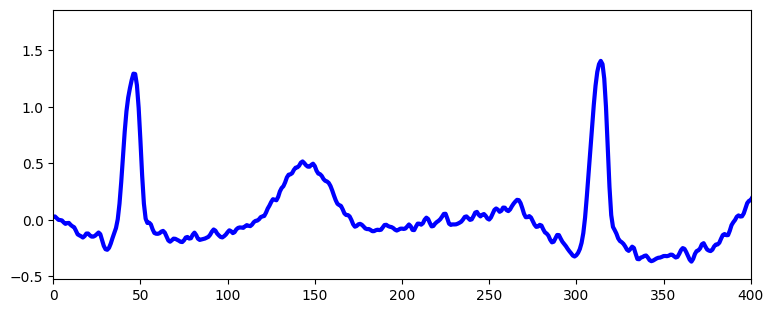

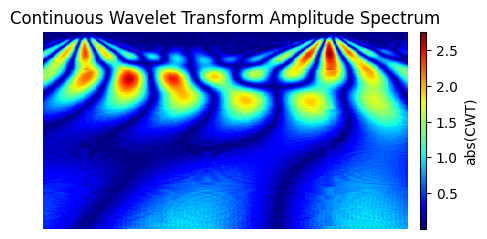

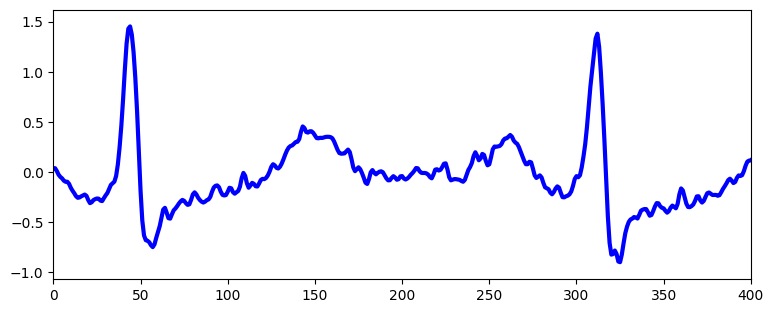

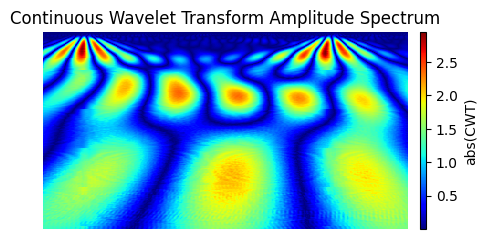

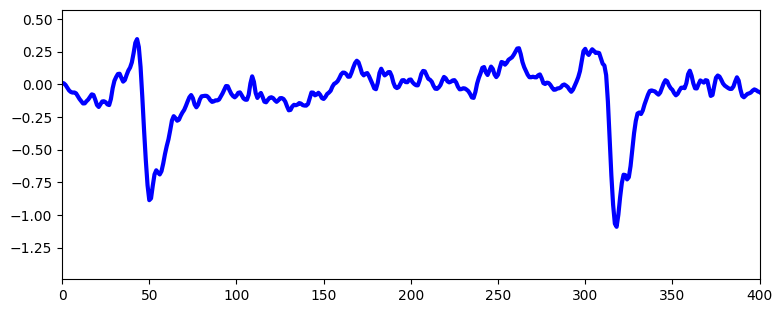

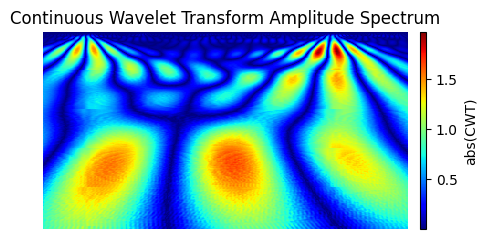

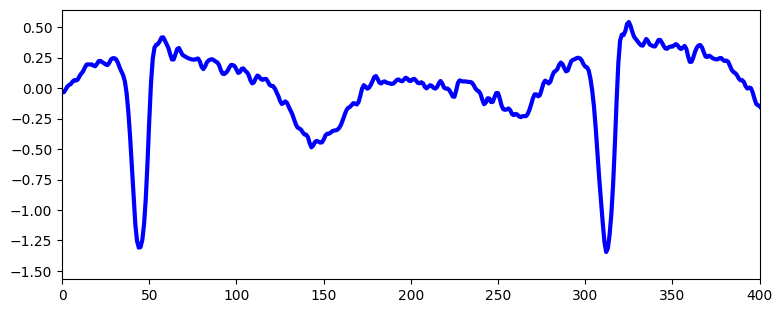

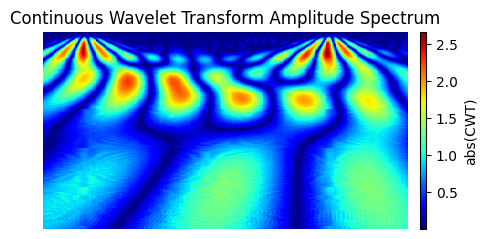

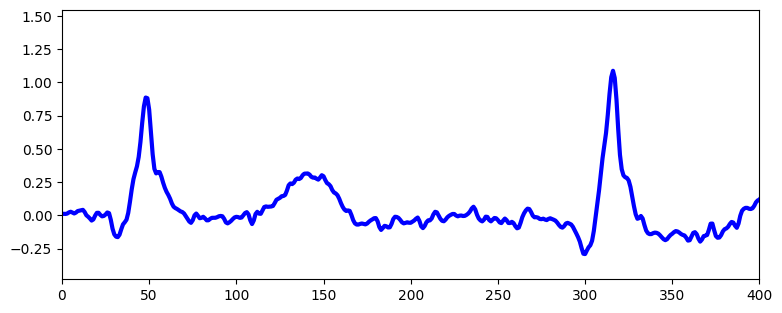

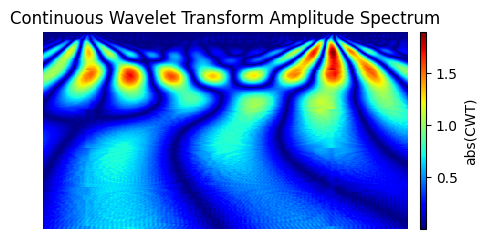

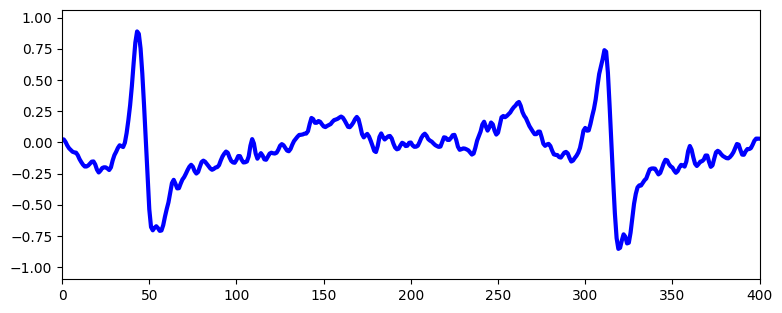

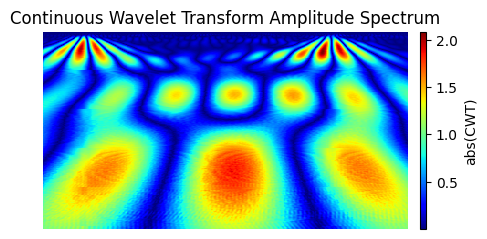

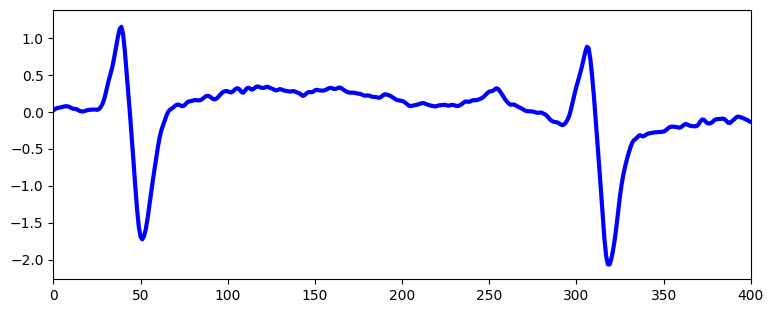

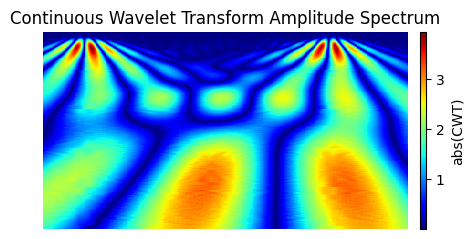

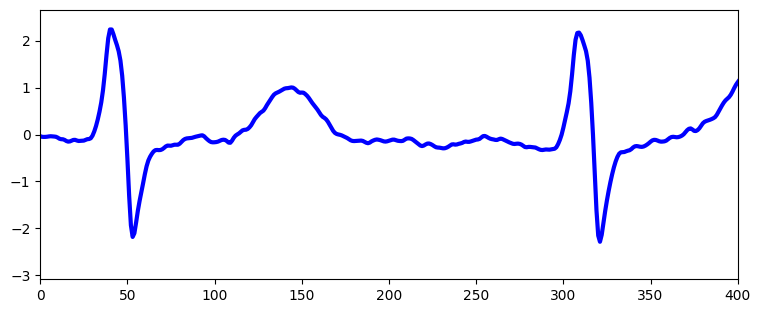

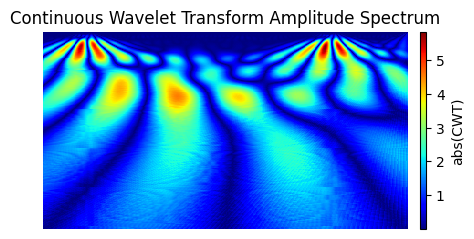

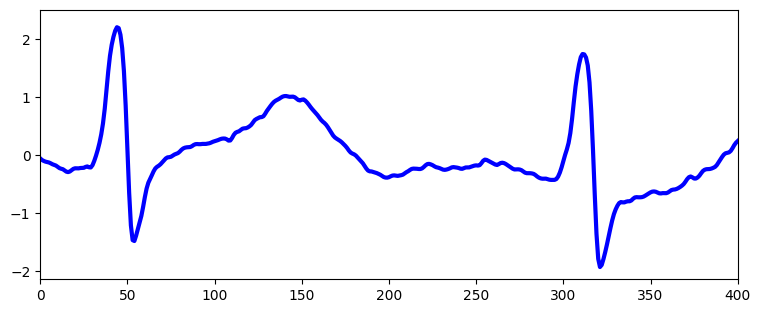

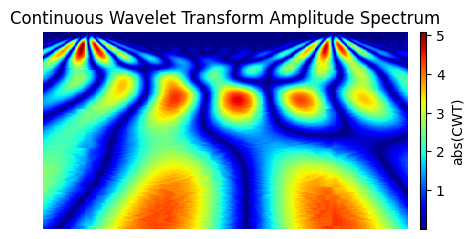

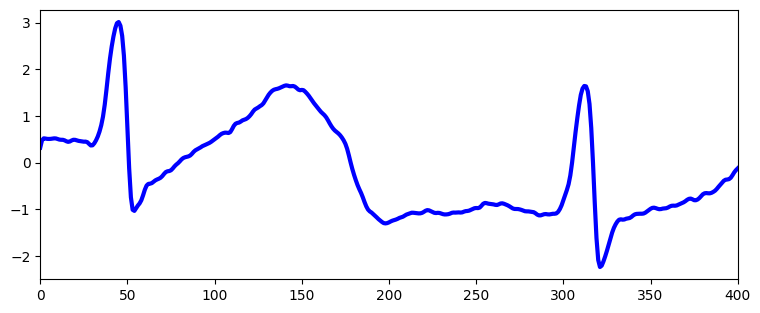

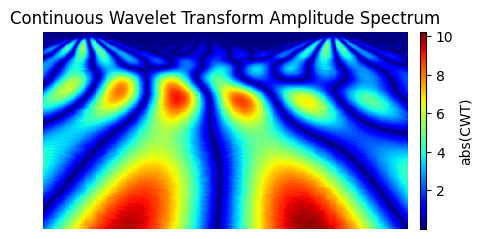

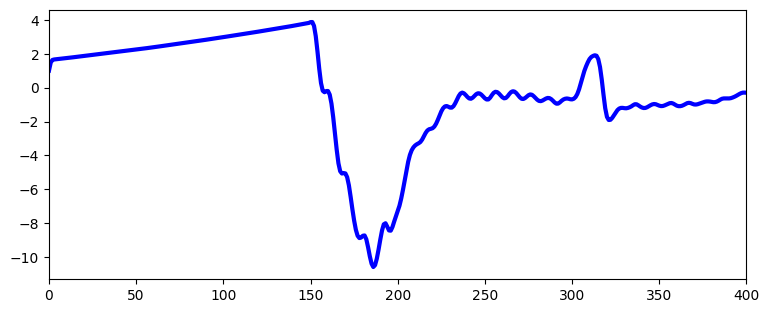

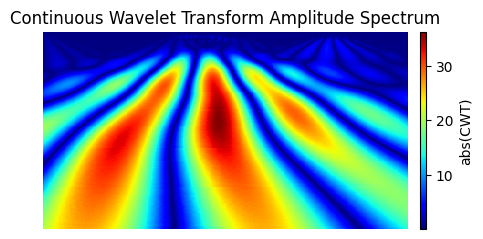

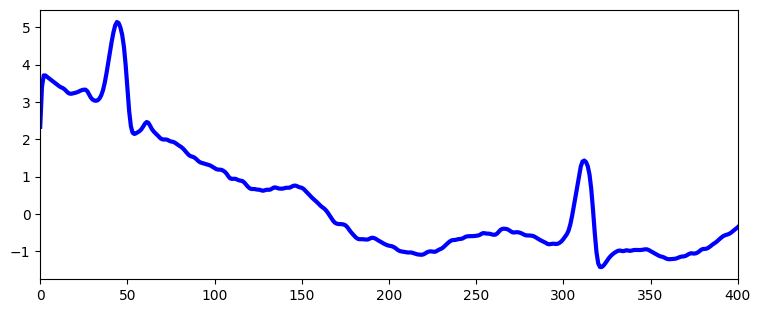

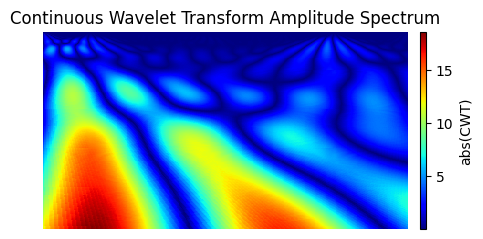

In [32]:
scaleogram(gauss_filt_list[:1], folder = "Gaussian_Filter")